In [ ]:
from scipy.optimize import minimize
from sklearn.model_selection import ParameterGrid
import numpy as np
import random
import matplotlib.pyplot as plt
import sobol_seq
from CartPole import *
from scipy import interpolate


# Task 4

In [ ]:
#non linear policy
def r_range(inpt, minimum, maximum):
    delta = inpt*(maximum-minimum)
    out = np.full(np.shape(inpt),minimum) + delta
    return out
def generate_data(n):
    data = sobol_seq.i4_sobol_generate(4,n)
    d_0= r_range(data[:,0],-10,10)
    d_1= r_range(data[:,1],-10,10)
    d_2= r_range(data[:,2],-np.pi,np.pi)
    d_3= r_range(data[:,3],-15,15)
    out = np.column_stack((d_0,d_1,d_2,d_3))
    return out

def kernel_func(x,x_i,W):
    x_change = x-x_i
    exp =(-0.5)* (x_change.transpose() @ W @ x_change)
    kernel = (np.e)**exp
    return kernel

def vector_K(current_state, basis_func, W):
    K = np.array([kernel_func(current_state, s, W) for s in basis_func])
    return K

N=500
X = generate_data(N)
M =8

In [ ]:
#Parameters to optimise
W11 = np.linspace(1,10, num=5)
W12 = np.linspace(1,10, num=5)
W13 = np.linspace(1,10, num=5)
W14 = np.linspace(1,10, num=5)
W22 = np.linspace(1,10, num=5)
W23 = np.linspace(1,10, num=5)
W24 = np.linspace(1,10, num=5)
W33 = np.linspace(1,10, num=5)
W34 = np.linspace(1,10, num=5)
W44 = np.linspace(1,10, num=5)

w0 = np.linspace(10, 50, num=5)
w1 = np.linspace(-10, 50, num=5)
w2 = np.linspace(10, 50, num=5)
w3 = np.linspace(-10, 50, num=5)
w4 = np.linspace(10, 50, num=5)
w5 = np.linspace(-10, 50, num=5)

param_grid = { 'w0':w0, 'w1':w1, 'w2':w2, 'w3':w3, 'w4':w4, 'w5':w5, 'W11': W11, 'W12' : W12, 'W13': W13, 'W14': W14, 'W22':W22,'W23':W23, 'W24':W24, 'W33':W33, 'W34':W34, 'W44':W44}
print(param_grid.keys())
parameters = ParameterGrid(param_grid)


dict_keys(['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'W11', 'W12', 'W13', 'W14', 'W22', 'W23', 'W24', 'W33', 'W34', 'W44'])


In [ ]:
def minimize_nonlinear_policy(parameters):
    #starting position is at the bottom
    init = [0,0,np.pi,0]
    #loss 
    l=0 
    #starting cost
    minimum_cost = 20
    minimum_parameters = []
    x= CartPole()

    for params in parameters:
        x.setState(init)
        #weight w_i
        w_i = np.array(params[:M])
        #4x4 matrix of W (symmetric)
        matrix_W = np.array([params[M:M+4],
                             [params[M+1],params[M+4],params[M+5],params[M+6]],
                             [params[M+2],params[M+5],params[M+7],params[M+8]],
                             [params[M+3],params[M+6],params[M+8],params[M+9]]])       

        for i in range(10):
            current_state = x.getState()
            #move the pole to the upright position, therefore will lay out the function into segments of different pole angle position
            #To the left of the upright position
            if -0.25*np.pi <= current_state[2]<0:
                #small force to push pole angle to the right
                move_s = np.array([0.3,np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003)])
                move_l = np.array([np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3)])
                move_matrix = np.array([move_l,move_s,move_l,move_s,move_l,move_s])
                current_matrix = np.array([current_state,]*6)
                matrix = current_matrix + move_matrix

            elif 0<=current_state[2]<0.25*np.pi:
                #pole angle to the right of the target location
                #move cart location to the right so that pole angle gets vertical
                move_s = np.array([0.3,np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003)])
                move_l = np.array([np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3)])
                move_matrix = np.array([move_s,move_l,move_s,move_l,move_s,move_l])
                current_matrix = np.array([current_state,]*6)
                matrix = current_matrix + move_matrix

            elif 0.25*np.pi <= current_state[2]<=np.pi:
                #pole angle at lower right quadrant
                #apply force, larger amount
                move_s = np.array([np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003)])
                move_l = np.array([np.random.uniform(0.3,0.5),np.random.uniform(0.3,0.5),np.random.uniform(0.3,0.5),np.random.uniform(0.3,0.5)])
                move_matrix = np.array([move_s,move_l,move_s,move_l,move_s,move_l])
                current_matrix = np.array([current_state,]*6)
                matrix = current_matrix + move_matrix

            elif -np.pi<=current_state[2]<-0.25*np.pi:
                #pole now on left quadrant
                #
                move_s = np.array([np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003)])
                move_l = np.array([np.random.uniform(0.3,0.5),np.random.uniform(0.3,0.5),np.random.uniform(0.3,0.5),np.random.uniform(0.3,0.5)])
                move_matrix = np.array([move_l,move_s,move_l,move_s,move_l,move_s,])
                current_matrix = np.array([current_state,]*6)
                matrix = current_matrix + move_matrix
            vector_k = vector_K(x.getState(),matrix, matrix_W)
            f = np.dot(w_i, vector_k)
            l+= abs(x.loss())
            x.performAction(f)
            x.remap_angle()
        return(l)


In [ ]:
def plot_nonlinear_policy_6(n,params):
    #starting position is at the bottom
    init = [0,1,np.pi,1]
    #loss 
    l=0 
    x= CartPole()
    x.setState(init)
    #weight w_i
    w_i = np.array(params[:M])
    #4x4 matrix of W (symmetric)
    matrix_W = np.array([params[M:M+4],
                        [params[M+1],params[M+4],params[M+5],params[M+6]],
                        [params[M+2],params[M+5],params[M+7],params[M+8]],
                        [params[M+3],params[M+6],params[M+8],params[M+9]]])       

    real_states = np.zeros([5,n])
    for i in range(n):
        current_state = x.getState()
        real_states[:4,i]=current_state
        #move the pole to the upright position, therefore will lay out the function into segments of different pole angle position
        #To the left of the upright position
        if -0.2*np.pi <= current_state[2]<0:
            #small force to push pole angle to the right
            move_s = np.array([-0.1,np.random.uniform(0.01,0.02),np.random.uniform(0.01,0.02),np.random.uniform(0.01,0.02)])
            move_l = np.array([np.random.uniform(0.1,0.2),np.random.uniform(0.1,0.2),np.random.uniform(0.1,0.2),np.random.uniform(0.1,0.2)])
            #move_matrix = np.array([move_l,move_s,move_l,move_s,move_l,move_s])
            move_matrix = np.array([move_s,move_s,move_s,move_s,move_s,move_s])
            current_matrix = np.array([current_state,]*6)
            matrix = current_matrix + move_matrix
            vector_k = vector_K(x.getState(),matrix, matrix_W)
            f =np.dot(w_i, vector_k)
            real_states[4,i]=f
            l+= abs(x.loss())
            x.performAction(f)
            #x.remap_angle()

        elif 0<=current_state[2]<0.2*np.pi:
            #pole angle to the right of the target location
            #move cart location to the right so that pole angle gets vertical
            move_s = np.array([0.2,np.random.uniform(0.01,0.02),np.random.uniform(0.01,0.02),np.random.uniform(0.001,0.02)])
            move_l = np.array([np.random.uniform(0.1,0.2),np.random.uniform(0.1,0.2),np.random.uniform(0.1,0.2),np.random.uniform(0.1,0.2)])
            #move_matrix = np.array([move_s,move_l,move_s,move_l,move_s,move_l])
            move_matrix = np.array([move_s,move_s,move_s,move_s,move_s,move_s])
            current_matrix = np.array([current_state,]*6)
            matrix = current_matrix + move_matrix
            vector_k = vector_K(x.getState(),matrix, matrix_W)
            f = -np.dot(w_i, vector_k)
            real_states[4,i]=f
            l+= abs(x.loss())
            x.performAction(f)
            #x.remap_angle()

        elif 0.2*np.pi <= current_state[2]<=np.pi:
            #pole angle at lower right quadrant
            #apply force, larger amount
            move_s = np.array([np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003)])
            move_l = np.array([np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3)])
            #move_matrix = np.array([move_s,move_l,move_s,move_l,move_s,move_l])
            move_matrix = np.array([move_l,move_l,move_l,move_l,move_l,move_l])
            current_matrix = np.array([current_state,]*6)
            matrix = current_matrix + move_matrix
            vector_k = vector_K(x.getState(),matrix, matrix_W)
            f = -np.dot(w_i, vector_k)
            real_states[4,i]=f
            l+= abs(x.loss())
            x.performAction(f)
            #x.remap_angle()

        elif -np.pi<=current_state[2]<-0.2*np.pi:
            #pole now on left quadrant
            #Use Larger Force 
            move_s = np.array([np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003)])
            move_l = np.array([np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3)])
            #move_matrix = np.array([move_l,move_s,move_l,move_s,move_l,move_s,])
            move_matrix = np.array([move_l,move_l,move_l,move_l,move_l,move_l])
            current_matrix = np.array([current_state,]*6)
            matrix = current_matrix + move_matrix
            vector_k = vector_K(x.getState(),matrix, matrix_W)
            f = np.dot(w_i, vector_k)
            real_states[4,i]=f
            l+= abs(x.loss())
            x.performAction(f)
            #x.remap_angle()
        
        else:
            p = [0.7051,1.21512,16.311,2.506]
            f=np.dot(x.getState(),p)
            real_states[4,i]=f
            l+= abs(x.loss())
            x.performAction(f)
            #x.remap_angle()

    fig,axs = plt.subplots(4, figsize = (12,6))
    fig.suptitle('Time Evolution of Variables, Non-Linear Policy')
    labels = ['Cart Location', 'Cart Velocity', 'Pole Angle', 'Pole Velocity']
    index=0
    t=np.arange(0,0.2*n,0.2)
    for i in range(4):
        x_new = np.linspace(0,0.2*n,1000)
        sp = interpolate.make_interp_spline(t, real_states[i])
        y_new = sp(x_new)
        axs[i].plot(x_new, y_new,'--',color='red')
        axs[i].set_xlim(0,0.2*n - 1)
        axs[i].set(xlabel='Time (s)')
        axs[i].set(ylabel= labels[index])
        index+=1
    plt.show()

In [ ]:
def plot_nonlinear_policy_min(params):
    #starting position is at the bottom
    n= 35
    init = [0,1,np.pi,1]
    #loss 
    l=0 
    x= CartPole()
    x.setState(init)
    #weight w_i
    w_i = np.array(params[:M])
    #4x4 matrix of W (symmetric)
    matrix_W = np.array([params[M:M+4],
                        [params[M+1],params[M+4],params[M+5],params[M+6]],
                        [params[M+2],params[M+5],params[M+7],params[M+8]],
                        [params[M+3],params[M+6],params[M+8],params[M+9]]])       

    real_states = np.zeros([5,n])
    for i in range(n):
        current_state = x.getState()
        real_states[:4,i]=current_state
        #move the pole to the upright position, therefore will lay out the function into segments of different pole angle position
        #To the left of the upright position
        if -0.2*np.pi <= current_state[2]<0:
            #small force to push pole angle to the right, move cart location to the left to make pole angle verticle
            move_s = np.array([-0.2,np.random.uniform(0.01,0.02),np.random.uniform(0.01,0.02),np.random.uniform(0.01,0.02)])
            #move_l = np.array([np.random.uniform(0.1,0.2),np.random.uniform(0.1,0.2),np.random.uniform(0.1,0.2),np.random.uniform(0.1,0.2)])
            move_matrix = np.array([move_s,move_s,move_s,move_s,move_s,move_s])
            current_matrix = np.array([current_state,]*6)
            matrix = current_matrix + move_matrix
            #vectorise with current state, move_movematrix and parameter matrix W
            vector_k = vector_K(x.getState(),matrix, matrix_W)
            #dot product with weight parameters
            f =np.dot(w_i, vector_k)
            real_states[4,i]=f
            l+= abs(x.loss())
            x.performAction(f)
            x.remap_angle()

        elif 0<=current_state[2]<0.2*np.pi:
            #pole angle to the right of the target location
            #move cart location to the right so that pole angle gets vertical
            move_s = np.array([0.2,np.random.uniform(0.01,0.02),np.random.uniform(0.01,0.02),np.random.uniform(0.001,0.02)])
            move_l = np.array([np.random.uniform(0.1,0.2),np.random.uniform(0.1,0.2),np.random.uniform(0.1,0.2),np.random.uniform(0.1,0.2)])
            #move_matrix = np.array([move_s,move_l,move_s,move_l,move_s,move_l])
            move_matrix = np.array([move_s,move_s,move_s,move_s,move_s,move_s])
            current_matrix = np.array([current_state,]*6)
            matrix = current_matrix + move_matrix
            vector_k = vector_K(x.getState(),matrix, matrix_W)
            f = np.dot(w_i, vector_k)
            real_states[4,i]=f
            l+= abs(x.loss())
            x.performAction(f)
            x.remap_angle()

        elif 0.2*np.pi <= current_state[2]<=np.pi:
            #pole angle at lower right quadrant
            #apply force, larger amount
            move_s = np.array([np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003)])
            move_l = np.array([np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3)])
            #move_matrix = np.array([move_s,move_l,move_s,move_l,move_s,move_l])
            move_matrix = np.array([move_l,move_l,move_l,move_l,move_l,move_l])
            current_matrix = np.array([current_state,]*6)
            matrix = current_matrix + move_matrix
            vector_k = vector_K(x.getState(),matrix, matrix_W)
            f = np.dot(w_i, vector_k)
            real_states[4,i]=f
            l+= abs(x.loss())
            x.performAction(f)
            x.remap_angle()

        elif -np.pi<=current_state[2]<-0.2*np.pi:
            #pole now on left quadrant
            #Use Larger Force 
            move_s = np.array([np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003),np.random.uniform(0.001,0.003)])
            move_l = np.array([np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3),np.random.uniform(0.1,0.3)])
            #move_matrix = np.array([move_l,move_s,move_l,move_s,move_l,move_s,])
            move_matrix = np.array([move_l,move_l,move_l,move_l,move_l,move_l])
            current_matrix = np.array([current_state,]*6)
            matrix = current_matrix + move_matrix
            vector_k = vector_K(x.getState(),matrix, matrix_W)
            f = np.dot(w_i, vector_k)
            real_states[4,i]=f
            l+= abs(x.loss())
            x.performAction(f)
            x.remap_angle()
        
        else:
            p = [0.7051,1.21512,16.311,2.506]
            f=np.dot(x.getState(),p)
            real_states[4,i]=f
            l+= abs(x.loss())
            x.performAction(f)
            x.remap_angle()

    return l

In [ ]:
res = minimize(plot_nonlinear_policy_min, p9,method='nelder-mead', options={'maxiter':1000,'xatol': 1e-3, 'disp': True})

Optimization terminated successfully.
         Current function value: 35.000000
         Iterations: 99
         Function evaluations: 321


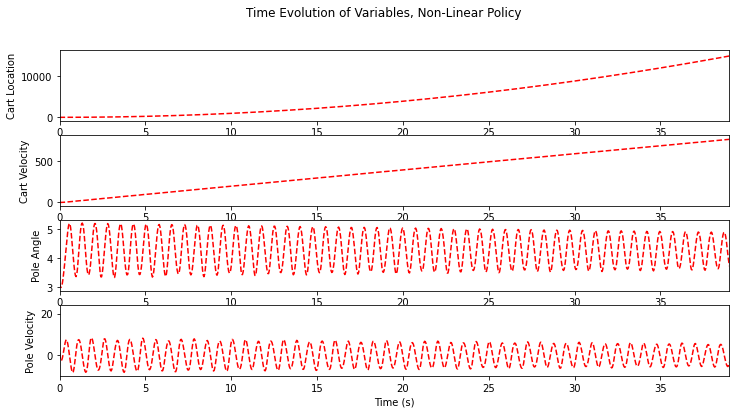

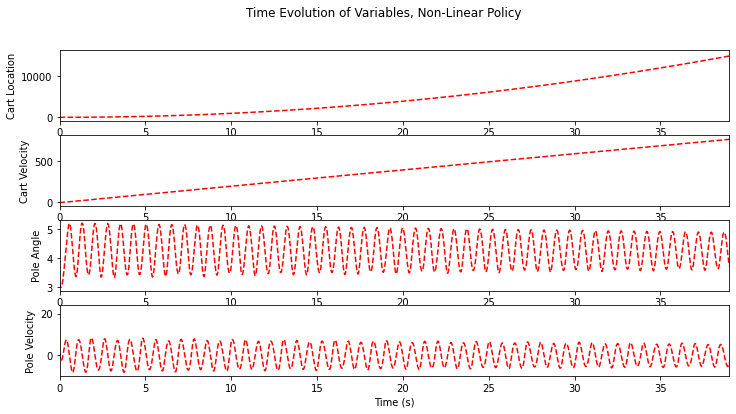

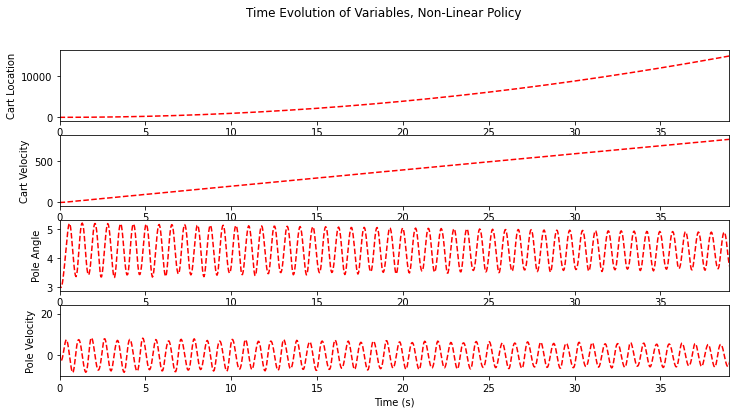

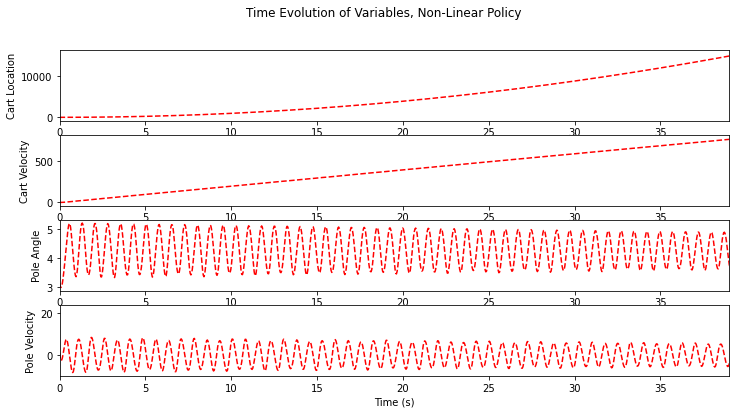

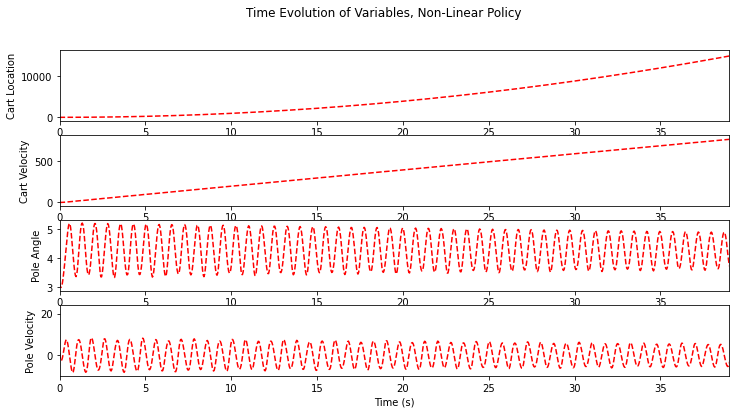

In [ ]:

parameters = np.array([-9.63057772e-02 , 1.05913213e+00 , 5.35467206e-01, -2.06306080e+00,
 -1.81705718e-01,  7.34564977e-01  ,1,1 ,1.95367308e+00 , 1.63891550e+00,
  1.96564419e+00 , 8.60649331e-01 , 6.32491794e+01 ,-2.19136075e+01,
  1.39949754e+01, -5.44140761e+01  ,8.46930693e+01 , 1.35122850e+02])

p1 = np.array([ 80.12023198, -70.10286497,  60.27731684, -50.2652867 ,
        39.80443738, -30.53120286,  69.97141661,  40.06854776,
        93.87713348,  10.03457368,  15.85072335,  24.99298657,
        37.04901057,  39.05599752,  77.03203416,  99.5027359 ])

p9 = np.array([  0.71024053,  -2.16650685,   1.25129557,  -0.48588814 ,  0.73267134,
    0.10798012  , 0.54509239,   1.30435411  , 1.22944109 ,  1.31908444,
   17.8682423 , -20.58035828  ,16.69400656 ,-11.85826296 , 48.64702953,
   37.99677849])
p10 = np.array([  0.71379326,  -2.17684077,   1.25721341,  -0.47443315,
         0.73680465,   0.10849419,   0.54774604,   1.31036358,
         1.24712616,   1.32568546,  17.9261973 , -20.52236115,
        16.6367209 , -11.91757582,  48.8730365 ,  37.83196885])
n=200
M=6
plot_nonlinear_policy_6(n, parameters1)
plot_nonlinear_policy_6(n, p1)
plot_nonlinear_policy_6(n, p9)
plot_nonlinear_policy_6(n, p10)
plot_nonlinear_policy_6(n, res.x)

In [ ]:
def is_pos_def(params):
    matrix_W = np.array([params[M:M+4],
                        [params[M+1],params[M+4],params[M+5],params[M+6]],
                        [params[M+2],params[M+5],params[M+7],params[M+8]],
                        [params[M+3],params[M+6],params[M+8],params[M+9]]])   
    return np.all(np.linalg.eigvals(matrix_W) > 0)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=180073fb-9c10-447b-b721-e7b1d25fe36a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>